# MNIST 1.x Bit

based on 
- https://github.com/pytorch/examples/blob/main/mnist/main.py
- the MNIST examples from https://www.physics.rutgers.edu/~dshih/694_2021/
- my multi-class code of the CaloChallenge

[by Claudius] 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.set_default_dtype(torch.float32)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

Using cuda:0


In [2]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
data_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
data_test = datasets.MNIST('../data', train=False, transform=transform)

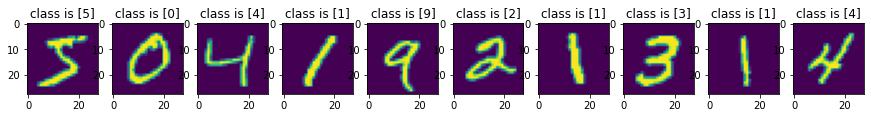

In [3]:
# for inspection only
num_imgs = 10
inspection_loader = DataLoader(data_train,batch_size=1)
fig = plt.figure(figsize=(15,15))
for idx, data in enumerate(inspection_loader):
    if idx < num_imgs:
        #print(idx)
        #print(data[0].size(), data[1])
        plt.subplot(1, num_imgs, idx+1)
        plt.imshow(data[0].squeeze().numpy())
        plt.title(f"class is {data[1].numpy()}")
    else:
        break
        
plt.show()

# works :-)

In [162]:
batch_size = 512
NUM_EPOCHS = 30
DIM_HIDDEN = 1024
NUM_HIDDEN = 1

train_loader = DataLoader(data_train,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test,batch_size=batch_size, shuffle=False)

## regular net

In [5]:
class RegularNet(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden=512, num_hidden=3, dpo=0.):
        super(RegularNet, self).__init__()
        
        self.dpo = dpo #dropout

        #self.inputlayer = torch.nn.Linear(dim_in, dim_hidden)
        #self.outputlayer = torch.nn.Linear(dim_hidden, 10)

        all_layers = [torch.nn.Linear(dim_in, dim_hidden), torch.nn.LeakyReLU(), torch.nn.Dropout(self.dpo)]
        for _ in range(num_hidden-1):
            all_layers.append(torch.nn.Linear(dim_hidden, dim_hidden))
            all_layers.append(torch.nn.LeakyReLU())
            all_layers.append(torch.nn.Dropout(self.dpo))

        all_layers.append(torch.nn.Linear(dim_hidden, 10))
        self.layers = torch.nn.Sequential(*all_layers)

    def forward(self, x):
        """ Forward pass through the DNN """
        x = self.layers(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

    
def find_accuracy(pred, label):
    overall = (np.argmax(pred, axis=-1) == label).astype(float) #.mean()
    return overall

def train_cls(model, dataloader_train, optim, epoch):
    """ train one step """
    model.train()
    train_loss = []
    for i, (data_batch, label_batch) in enumerate(dataloader_train):
        optim.zero_grad()
        data_batch = data_batch.reshape(-1, 28*28).to(device)
        output = model(data_batch)
        criterion = torch.nn.NLLLoss(reduction='none')
        
        loss = criterion(output, label_batch.to(device))
        train_loss.append(loss.tolist())

        loss.mean().backward()
        optim.step()

        if i % (len(dataloader_train)//4) == 0:
            print('Epoch {:3d} / {}, step {:4d} / {}; loss {:.4f}'.format(
                epoch+1, NUM_EPOCHS, i, len(dataloader_train), loss.mean().item()))
    train_loss = np.concatenate([*train_loss]).flatten()
    print(train_loss.shape)
    return train_loss.mean()

        # PREDICTIONS
        #pred = torch.round(torch.sigmoid(output_vector.detach()))
        #target = torch.round(target_vector.detach())
        #if i == 0:
        #    res_true = target
        #    res_pred = pred
        #else:
        #    res_true = torch.cat((res_true, target), 0)
        #    res_pred = torch.cat((res_pred, pred), 0)

    #print("Accuracy on training set is",
    #      accuracy_score(res_true.cpu(), res_pred.cpu()))


@torch.no_grad()
def evaluate_cls(model, dataloader_test):
    """ evaluate on test set """
    model.eval()
    eval_loss = []
    acc = []
    for j, (data_batch, label_batch) in enumerate(dataloader_test):
        
        data_batch = data_batch.reshape(-1, 28*28).to(device)
        pred = model(data_batch)
        loss = torch.nn.NLLLoss(reduction='none')(pred, label_batch.to(device))
        eval_loss.append(loss.tolist())
        local_acc = find_accuracy(np.exp(pred.cpu().numpy()), label_batch.cpu().numpy())
        acc.append(local_acc)
        
    eval_loss = np.concatenate([*eval_loss]).flatten()
    acc = np.concatenate([*acc]).flatten()
    print(f"Evaluation loss {eval_loss.mean()}, accuracy {acc.mean()}")
    return eval_loss, acc


@torch.no_grad()
def get_prediction(model, dataloader, device=None):
    model.eval()
    preds = []
    for data_batch, label_batch in dataloader:            
        batch_data = batch_data.to(device)
        label_batch = label_batch.to(device)            
        
        batch_preds = np.array(model(batch_data).tolist())
        
        preds.append(np.concatenate((batch_preds, batch_labels.reshape(-1, 1).tolist()), axis=1))
    preds = np.concatenate([*preds])
    print("preds shape", preds.shape)
    preds[:, :-1] = np.exp(preds[:, :-1])
    return preds

def save_weights(model, name):
    """ saves the model to file """
    file_name = f'{name}_weights.pt'
    torch.save({'model_state_dict': model.state_dict()}, file_name)
    print("Model saved")

def load_weights(model, name):
    """ loads the model from file """
    file_name = f'{name}_weights.pt'
    checkpoint = torch.load(file_name, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"Model {file_name} loaded")
    
def log_posterior(preds):
    """ log posterior scores = sum_{x in geant} log p(C|x) where C = model i """
    return np.log(preds+1e-99).mean(axis=0)


RegularNet(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)
classifier has 814090 parameters
Evaluation loss 2.329176826918125, accuracy 0.1028
Epoch 1 / 30
Epoch   1 / 30, step    0 / 118; loss 2.3322
Epoch   1 / 30, step   29 / 118; loss 0.3043
Epoch   1 / 30, step   58 / 118; loss 0.2342
Epoch   1 / 30, step   87 / 118; loss 0.2890
Epoch   1 / 30, step  116 / 118; loss 0.2496
(60000,)
Evaluation loss 0.20211548723163777, accuracy 0.9422
Model saved
   - - - - -   
Epoch 2 / 30
Epoch   2 / 30, step    0 / 118; loss 0.1727
Epoch   2 / 30, step   29 / 118; loss 0.2094
Epoch   2 / 30, step   58 / 118; loss 0.1300
Epoch   2 / 30, step   87 / 118; loss 0.1102
Epoch   2 / 30, step  116 / 118; loss 0.1329
(60000,)
Evaluation loss 0.13200697814240314, accuracy 0.9633
Model saved
   - - - - -   
Epoch 3 / 30
E

Epoch  25 / 30, step   87 / 118; loss 0.0012
Epoch  25 / 30, step  116 / 118; loss 0.0014
(60000,)
Evaluation loss 0.0563073923158429, accuracy 0.9833
   - - - - -   
Epoch 26 / 30
Epoch  26 / 30, step    0 / 118; loss 0.0013
Epoch  26 / 30, step   29 / 118; loss 0.0010
Epoch  26 / 30, step   58 / 118; loss 0.0011
Epoch  26 / 30, step   87 / 118; loss 0.0011
Epoch  26 / 30, step  116 / 118; loss 0.0010
(60000,)
Evaluation loss 0.057123888415245884, accuracy 0.9829
   - - - - -   
Epoch 27 / 30
Epoch  27 / 30, step    0 / 118; loss 0.0015
Epoch  27 / 30, step   29 / 118; loss 0.0011
Epoch  27 / 30, step   58 / 118; loss 0.0011
Epoch  27 / 30, step   87 / 118; loss 0.0009
Epoch  27 / 30, step  116 / 118; loss 0.0010
(60000,)
Evaluation loss 0.055980800540659924, accuracy 0.9828
   - - - - -   
Epoch 28 / 30
Epoch  28 / 30, step    0 / 118; loss 0.0010
Epoch  28 / 30, step   29 / 118; loss 0.0007
Epoch  28 / 30, step   58 / 118; loss 0.0009
Epoch  28 / 30, step   87 / 118; loss 0.0010
Epo

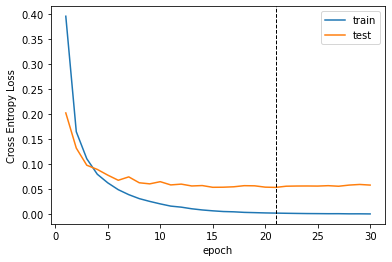

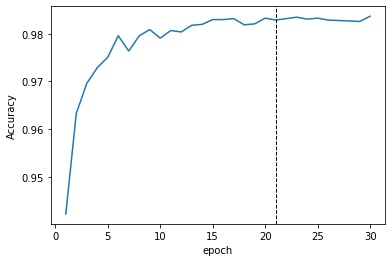

Model regular_1_1024_weights.pt loaded
Evaluation loss 0.05367459541904653, accuracy 0.9829
done


In [163]:
# set up DNN classifier

DNN_kwargs = {'num_hidden': NUM_HIDDEN,
              'dim_hidden':DIM_HIDDEN,
              'dim_in': 28*28,
              'dpo': 0.}
classifier = RegularNet(**DNN_kwargs)
classifier.to(device)
print(classifier)
total_parameters = sum(p.numel() for p in classifier.parameters() if p.requires_grad)

print("classifier has {} parameters".format(int(total_parameters)))

optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)

best_val_loss = 1e6

    
accuracy = []
_, acc = evaluate_cls(classifier, test_loader)
accuracy.append(acc.mean())

train_losses = []
eval_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1} / {NUM_EPOCHS}")
    train_loss = train_cls(classifier, train_loader, optimizer, epoch)
    eval_loss, acc = evaluate_cls(classifier, test_loader)
    train_losses.append(train_loss.mean())
    eval_losses.append(eval_loss.mean())
    accuracy.append(acc.mean())
    if eval_loss.mean() < best_val_loss:
        save_weights(classifier, f'regular_{NUM_HIDDEN}_{DIM_HIDDEN}')
        best_val_loss = eval_loss.mean()
    print("   - - - - -   ")
    
print("evaluating this run:")
epochs = np.arange(NUM_EPOCHS) + 1
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, eval_losses, label='test')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("epoch")
plt.axvline(x = np.argmin(eval_losses)+1, color = 'k', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

plt.plot(epochs, accuracy[1:])
plt.axvline(x = np.argmin(eval_losses)+1, color = 'k', linestyle='dashed', linewidth=1)
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.show()

load_weights(classifier, f'regular_{NUM_HIDDEN}_{DIM_HIDDEN}')
_ = evaluate_cls(classifier, test_loader)
print("done")
# while training on nvidia-smi: 1103MiB usage

Model regular_1_1024_weights.pt loaded
Evaluation loss 0.05367459541904653, accuracy 0.9829


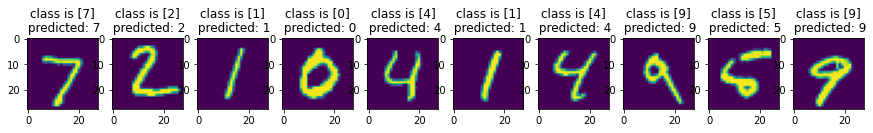

In [164]:
# for inspection only
load_weights(classifier, f'regular_{NUM_HIDDEN}_{DIM_HIDDEN}')
_ = evaluate_cls(classifier, test_loader)

num_imgs = 10
inspection_loader = DataLoader(data_test,batch_size=1)
fig = plt.figure(figsize=(15,15))
for idx, data in enumerate(inspection_loader):
    if idx < num_imgs:
        #print(idx)
        #print(data[0].size(), data[1])
        probs = np.exp(classifier(data[0].reshape(-1, 28*28).to(device)).cpu().detach().numpy())
        plt.subplot(1, num_imgs, idx+1)
        plt.imshow(data[0].squeeze().numpy())
        plt.title(f"class is {data[1].numpy()}\n predicted: {np.argmax(probs)}")
    else:
        break
        
plt.show()

# works :-)

## BitNet

In [8]:
# classes taken from https://github.com/ramonpeter/hep-bitnet/blob/main/bitnet/bitlinear.py
# commit: final edit 2df920c

class BitLinear(nn.Linear):
    """
    BitLinear is a custom linear layer that performs binarization of weights and quantization of activations

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        b: int = 8,
    ):
        super().__init__(in_features, out_features, bias)
        self.in_features = in_features
        self.out_features = out_features
        self.eps = 1e-8
        self.norm = nn.LayerNorm(in_features)

        # Quantiziation and dequantization
        self.Q_b = 2 ** (b - 1)  # use this to define quantized bit
        self.beta = torch.zeros((self.weight.shape[0], 1))
        self.gamma = torch.zeros((self.weight.shape[0], 1))

    def ste(self, x):
        """
        Applies the sign function for binarization and uses Straight-Through Estimator (STE) during backward pass.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Binarized tensor.
        """
        binarized_x = torch.sign(x)
        binarized_x = (binarized_x - x).detach() + x
        return binarized_x

    def binarize_weights(self):
        """
        Binarizes the weights of the layer using STE.

        Returns:
            Tensor: Binarized weights tensor.
        """
        alpha = self.weight.mean()
        self.beta = self.weight.abs().mean()
        binarized_weights = self.ste(self.weight - alpha)

        return binarized_weights

    def quantize_activations(self, x):
        """
        Quantizes the activations of the layer.

        Args:
            x (Tensor): Input tensor.
            b (int, optional): Number of bits for quantization. Default is 8.

        Returns:
            Tensor: Quantized activations tensor.
        """
        self.gamma = x.abs().max()
        quantized_x = torch.clamp(
            x * self.Q_b / (self.gamma + self.eps),
            -self.Q_b + self.eps,
            self.Q_b - 1.0 - self.eps,
        )
        return quantized_x

    def dequantize_activations(self, x):
        """
        Dequantizes the activations of the layer.

        Args:
            x (Tensor): Quantized input tensor.

        Returns:
            Tensor: Dequantized activations tensor.
        """
        return x * self.gamma * self.beta / self.Q_b

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the BitLinear layer.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor.
        """
        # Normalize input
        x = self.norm(x)

        # Binarize weights and quantize activations
        binarized_weights = self.binarize_weights()

        # Quantize input
        x_quant = self.quantize_activations(x)

        # Perform linear transformation
        output = torch.nn.functional.linear(x_quant, binarized_weights, self.bias)

        # Dequantize activations
        output = self.dequantize_activations(output)

        # Return output
        return output


class BitNet(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden=512, num_hidden=3):
        super(BitNet, self).__init__()
        
        all_layers = [BitLinear(dim_in, dim_hidden), nn.LeakyReLU()]
        for _ in range(num_hidden-1):
            all_layers.append(BitLinear(dim_hidden, dim_hidden))
            all_layers.append(nn.LeakyReLU())
            #all_layers.append(torch.nn.Dropout(self.dpo))

        all_layers.append(BitLinear(dim_hidden, 10))
        self.layers = torch.nn.Sequential(*all_layers)

    def forward(self, x):
        """ Forward pass through the DNN """
        x = self.layers(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

BitNet(
  (layers): Sequential(
    (0): BitLinear(
      in_features=784, out_features=1024, bias=True
      (norm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): BitLinear(
      in_features=1024, out_features=10, bias=True
      (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)
bit classifier has 817706 parameters
Evaluation loss 2.4307011242747305, accuracy 0.08
Epoch 1 / 30
Epoch   1 / 30, step    0 / 118; loss 2.4348
Epoch   1 / 30, step   29 / 118; loss 0.3508
Epoch   1 / 30, step   58 / 118; loss 0.2944
Epoch   1 / 30, step   87 / 118; loss 0.2176
Epoch   1 / 30, step  116 / 118; loss 0.1548
(60000,)
Evaluation loss 0.14900790026568467, accuracy 0.9567
Model saved
   - - - - -   
Epoch 2 / 30
Epoch   2 / 30, step    0 / 118; loss 0.1069
Epoch   2 / 30, step   29 / 118; loss 0.1287
Epoch   2 / 30, step   58 / 118; loss 0.1259
Epoch   2 / 30, step   87 / 118; loss 0.0718
Epoch   2 / 30, step  

Epoch  25 / 30, step   58 / 118; loss 0.0001
Epoch  25 / 30, step   87 / 118; loss 0.0001
Epoch  25 / 30, step  116 / 118; loss 0.0001
(60000,)
Evaluation loss 0.07521026970109874, accuracy 0.983
   - - - - -   
Epoch 26 / 30
Epoch  26 / 30, step    0 / 118; loss 0.0001
Epoch  26 / 30, step   29 / 118; loss 0.0001
Epoch  26 / 30, step   58 / 118; loss 0.0001
Epoch  26 / 30, step   87 / 118; loss 0.0001
Epoch  26 / 30, step  116 / 118; loss 0.0001
(60000,)
Evaluation loss 0.0754272603093656, accuracy 0.983
   - - - - -   
Epoch 27 / 30
Epoch  27 / 30, step    0 / 118; loss 0.0001
Epoch  27 / 30, step   29 / 118; loss 0.0001
Epoch  27 / 30, step   58 / 118; loss 0.0001
Epoch  27 / 30, step   87 / 118; loss 0.0001
Epoch  27 / 30, step  116 / 118; loss 0.0001
(60000,)
Evaluation loss 0.07596254803816212, accuracy 0.9832
   - - - - -   
Epoch 28 / 30
Epoch  28 / 30, step    0 / 118; loss 0.0000
Epoch  28 / 30, step   29 / 118; loss 0.0001
Epoch  28 / 30, step   58 / 118; loss 0.0001
Epoch  

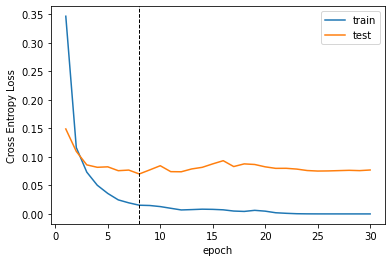

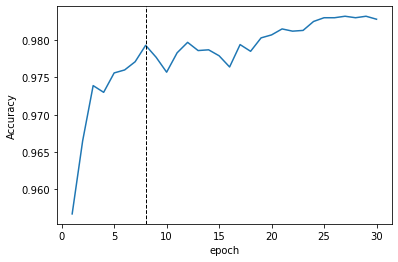

Model bit_1_1024_weights.pt loaded
Evaluation loss 0.07009595110271138, accuracy 0.9793
done


In [165]:
# set up BitDNN classifier

BitDNN_kwargs = {'num_hidden': NUM_HIDDEN,
                 'dim_hidden': DIM_HIDDEN,
                 'dim_in': 28*28}
bit_classifier = BitNet(**BitDNN_kwargs)
bit_classifier.to(device)
print(bit_classifier)
total_parameters = sum(p.numel() for p in bit_classifier.parameters() if p.requires_grad)

print("bit classifier has {} parameters".format(int(total_parameters)))

optimizer = torch.optim.Adam(bit_classifier.parameters(), lr=5e-4)

best_val_loss = 1e6
    
accuracy = []
_, acc = evaluate_cls(bit_classifier, test_loader)
accuracy.append(acc.mean())

train_losses = []
eval_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1} / {NUM_EPOCHS}")
    train_loss = train_cls(bit_classifier, train_loader, optimizer, epoch)
    eval_loss, acc = evaluate_cls(bit_classifier, test_loader)
    train_losses.append(train_loss.mean())
    eval_losses.append(eval_loss.mean())
    accuracy.append(acc.mean())
    if eval_loss.mean() < best_val_loss:
        save_weights(bit_classifier, f'bit_{NUM_HIDDEN}_{DIM_HIDDEN}')
        best_val_loss = eval_loss.mean()
    print("   - - - - -   ")
    
print("evaluating this run:")
epochs = np.arange(NUM_EPOCHS) + 1
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, eval_losses, label='test')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("epoch")
plt.axvline(x = np.argmin(eval_losses)+1, color = 'k', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

plt.plot(epochs, accuracy[1:])
plt.axvline(x = np.argmin(eval_losses)+1, color = 'k', linestyle='dashed', linewidth=1)
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.show()

load_weights(bit_classifier, f'bit_{NUM_HIDDEN}_{DIM_HIDDEN}')
_ = evaluate_cls(bit_classifier, test_loader)
print("done")
# while training on nvidia-smi: 1153MiB usage, but cache was not cleared after regular DNN above

Model bit_1_1024_weights.pt loaded
Evaluation loss 0.07009595110271138, accuracy 0.9793


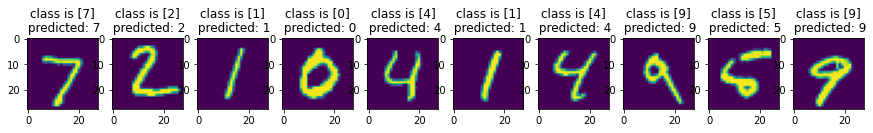

In [166]:
# for inspection only
load_weights(bit_classifier, f'bit_{NUM_HIDDEN}_{DIM_HIDDEN}')
_ = evaluate_cls(bit_classifier, test_loader)

num_imgs = 10
inspection_loader = DataLoader(data_test,batch_size=1)
fig = plt.figure(figsize=(15,15))
for idx, data in enumerate(inspection_loader):
    if idx < num_imgs:
        #print(idx)
        #print(data[0].size(), data[1])
        probs = np.exp(bit_classifier(data[0].reshape(-1, 28*28).to(device)).cpu().detach().numpy())
        plt.subplot(1, num_imgs, idx+1)
        plt.imshow(data[0].squeeze().numpy())
        plt.title(f"class is {data[1].numpy()}\n predicted: {np.argmax(probs)}")
    else:
        break
        
plt.show()

# works :-)

In [14]:
# what weights were saved?
file_name = 'bit_weights.pt'
checkpoint = torch.load(file_name, map_location=device)
print(checkpoint['model_state_dict'])


OrderedDict([('layers.0.weight', tensor([[ 0.0112,  0.0174, -0.0245,  ...,  0.0133, -0.0282,  0.0320],
        [-0.0023, -0.0318, -0.0244,  ..., -0.0325,  0.0351,  0.0257],
        [ 0.0027,  0.0047, -0.0181,  ..., -0.0031, -0.0058, -0.0349],
        ...,
        [ 0.0114, -0.0255, -0.0213,  ...,  0.0268,  0.0151,  0.0289],
        [-0.0025,  0.0322, -0.0116,  ..., -0.0089,  0.0305,  0.0042],
        [-0.0269,  0.0290, -0.0174,  ..., -0.0029,  0.0040,  0.0213]],
       device='cuda:0')), ('layers.0.bias', tensor([-2.5581e-02,  1.5429e-02, -1.3789e-02,  2.5085e-02,  2.0157e-02,
        -1.0812e-02, -2.0739e-02,  2.3683e-02,  2.7345e-03,  3.4012e-03,
        -2.8794e-02,  3.6922e-02, -2.9689e-02,  2.2047e-03, -1.6775e-02,
        -1.4069e-02, -1.7770e-02,  6.0249e-03,  2.2233e-02, -1.0902e-02,
         5.6186e-04,  1.4238e-02,  3.2812e-02,  8.4506e-03,  2.5095e-02,
         2.3160e-02, -1.8035e-02,  7.7501e-03,  4.4736e-03, -3.5563e-02,
        -2.5960e-02,  2.4606e-02, -2.6605e-02,  2.0

## BitNet 1.58

In [13]:
class BitLinear158b(BitLinear):
    """
    BitLinear158b layer allowing for tertiar weights (-1,0,1). Rest is keeped
    as in BitLinear

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
        num_groups (int, optional): Number of groups to divide the weights and activations into. Default is 1.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        b: int = 8,
    ):
        super().__init__(in_features, out_features, bias, b)

    def _absmean_quantization(self, weight, gamma):
        quantized_weight = torch.clamp(
            torch.round(weight / (gamma + self.eps)), min=-1, max=1
        )
        quantized_weight = (quantized_weight - weight).detach() + weight
        return quantized_weight

    def binarize_weights(self):
        """
        Quantizes the weights using the absmean quantization function.

        Returns:
            Tensor: Quantized weight tensor.
        """
        self.beta = self.weight.abs().mean()
        binarized_weight = self._absmean_quantization(self.weight, self.beta)

        return binarized_weight



class Bit158bNet(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden=512, num_hidden=3):
        super(Bit158bNet, self).__init__()
        
        all_layers = [BitLinear158b(dim_in, dim_hidden), nn.LeakyReLU()]
        for _ in range(num_hidden-1):
            all_layers.append(BitLinear158b(dim_hidden, dim_hidden))
            all_layers.append(nn.LeakyReLU())
            #all_layers.append(torch.nn.Dropout(self.dpo))

        all_layers.append(BitLinear158b(dim_hidden, 10))
        self.layers = torch.nn.Sequential(*all_layers)

    def forward(self, x):
        """ Forward pass through the DNN """
        x = self.layers(x)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

Bit158bNet(
  (layers): Sequential(
    (0): BitLinear158b(
      in_features=784, out_features=1024, bias=True
      (norm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): BitLinear158b(
      in_features=1024, out_features=10, bias=True
      (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
)
bit 1.58b classifier has 817706 parameters
Evaluation loss 2.42228581109643, accuracy 0.0876
Epoch 1 / 30
Epoch   1 / 30, step    0 / 118; loss 2.4546
Epoch   1 / 30, step   29 / 118; loss 0.4222
Epoch   1 / 30, step   58 / 118; loss 0.1764
Epoch   1 / 30, step   87 / 118; loss 0.1776
Epoch   1 / 30, step  116 / 118; loss 0.1297
(60000,)
Evaluation loss 0.13807415160574818, accuracy 0.9595
Model saved
   - - - - -   
Epoch 2 / 30
Epoch   2 / 30, step    0 / 118; loss 0.0971
Epoch   2 / 30, step   29 / 118; loss 0.1073
Epoch   2 / 30, step   58 / 118; loss 0.0921
Epoch   2 / 30, step   87 / 118; loss 0.1498
Epoc

Epoch  25 / 30, step   29 / 118; loss 0.0001
Epoch  25 / 30, step   58 / 118; loss 0.0001
Epoch  25 / 30, step   87 / 118; loss 0.0001
Epoch  25 / 30, step  116 / 118; loss 0.0001
(60000,)
Evaluation loss 0.07397213889503032, accuracy 0.9823
   - - - - -   
Epoch 26 / 30
Epoch  26 / 30, step    0 / 118; loss 0.0001
Epoch  26 / 30, step   29 / 118; loss 0.0001
Epoch  26 / 30, step   58 / 118; loss 0.0001
Epoch  26 / 30, step   87 / 118; loss 0.0001
Epoch  26 / 30, step  116 / 118; loss 0.0001
(60000,)
Evaluation loss 0.07474917398636165, accuracy 0.9829
   - - - - -   
Epoch 27 / 30
Epoch  27 / 30, step    0 / 118; loss 0.0001
Epoch  27 / 30, step   29 / 118; loss 0.0001
Epoch  27 / 30, step   58 / 118; loss 0.0001
Epoch  27 / 30, step   87 / 118; loss 0.0001
Epoch  27 / 30, step  116 / 118; loss 0.0001
(60000,)
Evaluation loss 0.07460114232978038, accuracy 0.9832
   - - - - -   
Epoch 28 / 30
Epoch  28 / 30, step    0 / 118; loss 0.0000
Epoch  28 / 30, step   29 / 118; loss 0.0000
Epoc

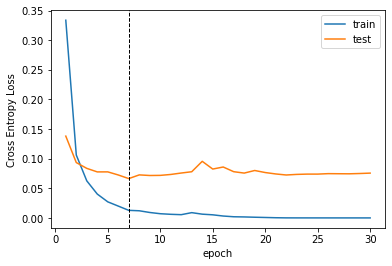

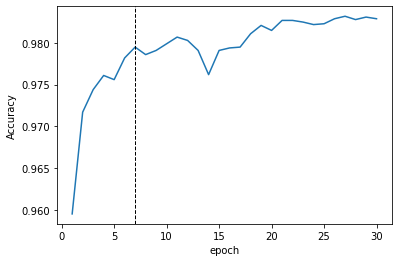

Model bit158b_1_1024_weights.pt loaded
Evaluation loss 0.06639320970656502, accuracy 0.9795
done


In [167]:
# set up Bit158bDNN classifier

Bit158bDNN_kwargs = {'num_hidden': NUM_HIDDEN,
                     'dim_hidden': DIM_HIDDEN,
                     'dim_in': 28*28}
bit158b_classifier = Bit158bNet(**Bit158bDNN_kwargs)
bit158b_classifier.to(device)
print(bit158b_classifier)
total_parameters = sum(p.numel() for p in bit158b_classifier.parameters() if p.requires_grad)

print("bit 1.58b classifier has {} parameters".format(int(total_parameters)))

optimizer = torch.optim.Adam(bit158b_classifier.parameters(), lr=5e-4)

best_val_loss = 1e6
    
accuracy = []
_, acc = evaluate_cls(bit158b_classifier, test_loader)
accuracy.append(acc.mean())

train_losses = []
eval_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1} / {NUM_EPOCHS}")
    train_loss = train_cls(bit158b_classifier, train_loader, optimizer, epoch)
    eval_loss, acc = evaluate_cls(bit158b_classifier, test_loader)
    train_losses.append(train_loss.mean())
    eval_losses.append(eval_loss.mean())
    accuracy.append(acc.mean())
    if eval_loss.mean() < best_val_loss:
        save_weights(bit158b_classifier, f'bit158b_{NUM_HIDDEN}_{DIM_HIDDEN}')
        best_val_loss = eval_loss.mean()
    print("   - - - - -   ")
    
print("evaluating this run:")
epochs = np.arange(NUM_EPOCHS) + 1
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, eval_losses, label='test')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("epoch")
plt.axvline(x = np.argmin(eval_losses)+1, color = 'k', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

plt.plot(epochs, accuracy[1:])
plt.axvline(x = np.argmin(eval_losses)+1, color = 'k', linestyle='dashed', linewidth=1)
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.show()

load_weights(bit158b_classifier, f'bit158b_{NUM_HIDDEN}_{DIM_HIDDEN}')
_ = evaluate_cls(bit158b_classifier, test_loader)
print("done")
# while training on nvidia-smi: 1155MiB usage, but cache of regular and Bit DNN was not cleared before

Model bit158b_1_1024_weights.pt loaded
Evaluation loss 0.06639320970656502, accuracy 0.9795


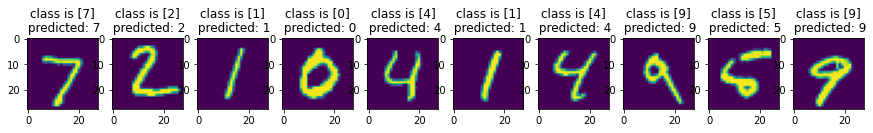

In [168]:
# for inspection only
load_weights(bit158b_classifier, f'bit158b_{NUM_HIDDEN}_{DIM_HIDDEN}')
_ = evaluate_cls(bit158b_classifier, test_loader)

num_imgs = 10
inspection_loader = DataLoader(data_test,batch_size=1)
fig = plt.figure(figsize=(15,15))
for idx, data in enumerate(inspection_loader):
    if idx < num_imgs:
        #print(idx)
        #print(data[0].size(), data[1])
        probs = np.exp(bit158b_classifier(data[0].reshape(-1, 28*28).to(device)).cpu().detach().numpy())
        plt.subplot(1, num_imgs, idx+1)
        plt.imshow(data[0].squeeze().numpy())
        plt.title(f"class is {data[1].numpy()}\n predicted: {np.argmax(probs)}")
    else:
        break
        
plt.show()


In [15]:
# what weights were saved?
file_name = 'bit158b_weights.pt'
checkpoint = torch.load(file_name, map_location=device)
print(checkpoint['model_state_dict'])


OrderedDict([('layers.0.weight', tensor([[-0.0320,  0.0201,  0.0113,  ...,  0.0213, -0.0221,  0.0320],
        [ 0.0205, -0.0131,  0.0210,  ...,  0.0167,  0.0160, -0.0003],
        [ 0.0124,  0.0178, -0.0231,  ...,  0.0020, -0.0222, -0.0191],
        ...,
        [ 0.0166, -0.0127,  0.0166,  ...,  0.0002, -0.0135, -0.0018],
        [-0.0179,  0.0153, -0.0307,  ...,  0.0215,  0.0203,  0.0216],
        [ 0.0143, -0.0218, -0.0330,  ...,  0.0143,  0.0223,  0.0273]],
       device='cuda:0')), ('layers.0.bias', tensor([ 5.7772e-01,  6.0369e-01,  7.1477e-01,  9.6591e-01,  8.6807e-01,
         5.9560e-01, -7.4897e-02, -2.1942e-01,  6.7321e-01, -6.7844e-01,
         1.6045e-01, -3.9938e-01,  1.0265e+00, -2.0613e-01, -3.2050e-01,
         3.6298e-01, -3.5653e-01,  7.6384e-01, -1.3094e+00, -5.4854e-01,
        -4.0741e-01, -1.1280e+00,  3.1567e-01, -9.2947e-01, -4.5522e-01,
        -3.6757e-01, -1.4275e-01,  3.2671e-01,  6.7569e-01,  4.7838e-01,
        -3.5936e-02, -4.3462e-01, -3.1224e-01, -9.0

## size comparisons

In [169]:
hidden_layers_3 = np.array([512, 256, 128, 64, 32, 16])
hidden_layers_2 = np.array([16, 32, 64, 128, 256, 512])
hidden_layers_1 = np.array([16, 32, 64, 128, 256, 512, 1024])

regular_3 = np.array([0.9814, 0.9789, 0.978, 0.9734, 0.9637, 0.9479])
regular_3_num = np.array([932362, 335114, 134794, 59210, 27562, 13274])

regular_2 = np.array([0.9475, 0.9666, 0.9745, 0.9778, 0.9802, 0.9815])
regular_2_num = np.array([13002, 26506, 55050, 118282, 269322, 669706])

regular_1 = np.array([0.9453, 0.9652, 0.9726, 0.9788, 0.9813, 0.9824, 0.9829])
regular_1_num = np.array([12730, 25450, 50890, 101770, 203530, 407050, 814090])


bit_3 = np.array([0.978, 0.9788, 0.9748, 0.9677, 0.9534, 0.9227])
bit_3_num = np.array([937002, 338218, 137130, 61162, 29322, 14938])

bit_2 = np.array([0.924, 0.9535, 0.9669, 0.9742, 0.9781, 0.9794])
bit_2_num = np.array([14634, 28202, 56874, 120362, 271914, 673322])

bit_1 = np.array([0.9216, 0.9493, 0.9663, 0.9717, 0.9747, 0.9774, 0.9793])
bit_1_num = np.array([14330, 27082, 52586, 103594, 205610, 409642, 817706])


bit158_3 = np.array([0.9828, 0.9812, 0.974, 0.9707, 0.9588, 0.9358])
bit158_3_num = np.array([937002, 338218, 137130, 61162, 29322, 14938])

bit158_2 = np.array([0.9332, 0.9587, 0.9711, 0.978, 0.98, 0.9773])
bit158_2_num = np.array([14634, 28202, 56874, 120362, 271914, 673322])

bit158_1 = np.array([0.9338, 0.9566, 0.9697, 0.9735, 0.9779, 0.9784, 0.9795])
bit158_1_num = np.array([14330, 27082, 52586, 103594, 205610, 409642, 817706])


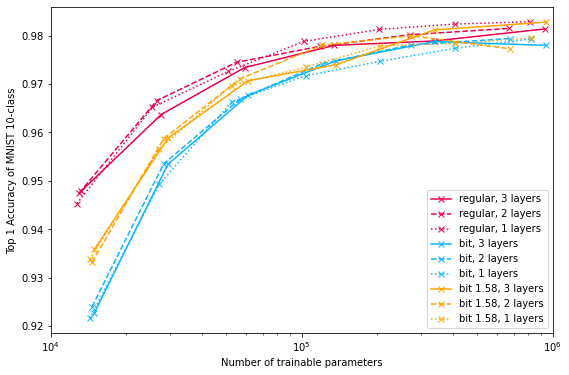

In [171]:
plt.figure(figsize=(9,6), facecolor='white')

colors = ["#e60049", "#0bb4ff", "#ffa300"]
styles = ["solid", "dashed", "dotted"]

plt.plot(regular_3_num, regular_3,"x",color=colors[0], label="regular, 3 layers", ls=styles[0])
plt.plot(regular_2_num, regular_2,"x",color=colors[0], label="regular, 2 layers", ls=styles[1])
plt.plot(regular_1_num, regular_1,"x",color=colors[0], label="regular, 1 layers", ls=styles[2])

plt.plot(bit_3_num, bit_3,"x",color=colors[1], label="bit, 3 layers", ls=styles[0])
plt.plot(bit_2_num, bit_2,"x",color=colors[1], label="bit, 2 layers", ls=styles[1])
plt.plot(bit_1_num, bit_1,"x",color=colors[1], label="bit, 1 layers", ls=styles[2])

plt.plot(bit158_3_num, bit158_3,"x",color=colors[2], label="bit 1.58, 3 layers", ls=styles[0])
plt.plot(bit158_2_num, bit158_2,"x",color=colors[2], label="bit 1.58, 2 layers", ls=styles[1])
plt.plot(bit158_1_num, bit158_1,"x",color=colors[2], label="bit 1.58, 1 layers", ls=styles[2])


plt.ylabel("Top 1 Accuracy of MNIST 10-class")
plt.xlabel("Number of trainable parameters")
plt.xscale('log')
plt.xlim([1e4, 1e6])
plt.legend(loc='lower right')
plt.show()